## Image Patches with Image网

We'd like to make use of the [Image网 dataset](https://github.com/fastai/imagenette/blob/master/README.md). My understanding is that it doesn't have labels so it would make sense to use as a dataset for our pretext tasks

In [20]:
import json

import numpy as np

from fastai2.basics import DataBlock, RandomSplitter

from fastai2.vision.all import ImageBlock, PILMask, get_image_files, PILImage, imagenet_stats
from fastai2.vision.core import get_annotations, Image, TensorBBox, TensorPoint, TensorImage
from fastai2.vision.augment import aug_transforms, RandomResizedCrop, RandTransform
from fastai2.vision.learner import unet_learner, unet_config

from fastai2.data.transforms import Normalize
from fastai2.data.external import download_url, URLs, untar_data

from torch.nn import MSELoss
from torchvision.models import resnet34

In [21]:
images_path = untar_data(URLs.IMAGEWANG_160)
# We'll use the unsupervised images
images_path = images_path/'unsup'

In [22]:
class PILImageInput(PILImage): pass

In [36]:
class RandomCutout(RandTransform):
    "Picks a random scaled crop of an image and resize it to `size`"
    split_idx = None
    def __init__(self, min_n_holes=5, max_n_holes=10, min_length=5, max_length=50, **kwargs):
        super().__init__(**kwargs)
        self.min_n_holes=min_n_holes
        self.max_n_holes=max_n_holes
        self.min_length=min_length
        self.max_length=max_length

    def encodes(self, x:PILImageInput):
        
        n_holes = np.random.randint(self.min_n_holes, self.max_n_holes)
        pixels = np.array(x) # Convert to mutable numpy array. FeelsBadMan
        h,w = pixels.shape[:2]

        for n in range(n_holes):
            h_length = np.random.randint(self.min_length, self.max_length)
            w_length = np.random.randint(self.min_length, self.max_length)
            h_y = np.random.randint(0, h)
            h_x = np.random.randint(0, w)
            y1 = int(np.clip(h_y - h_length / 2, 0, h))
            y2 = int(np.clip(h_y + h_length / 2, 0, h))
            x1 = int(np.clip(h_x - w_length / 2, 0, w))
            x2 = int(np.clip(h_x + w_length / 2, 0, w))
           
            pixels[y1:y2, x1:x2, :] = 0
            
        return Image.fromarray(pixels, mode='RGB')

In [37]:
data = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: o)

In [38]:
databunch = data.databunch(images_path, 
                           bs=10, 
                           item_tfms=[RandomResizedCrop(160), RandomCutout()], 
                           batch_tfms=[*aug_transforms(size=160, max_warp=0, max_rotate=0)])
# HACK: We're predicting pixel values, so we're just going to predict an output for each RGB channel
databunch.vocab = ['R', 'G', 'B']

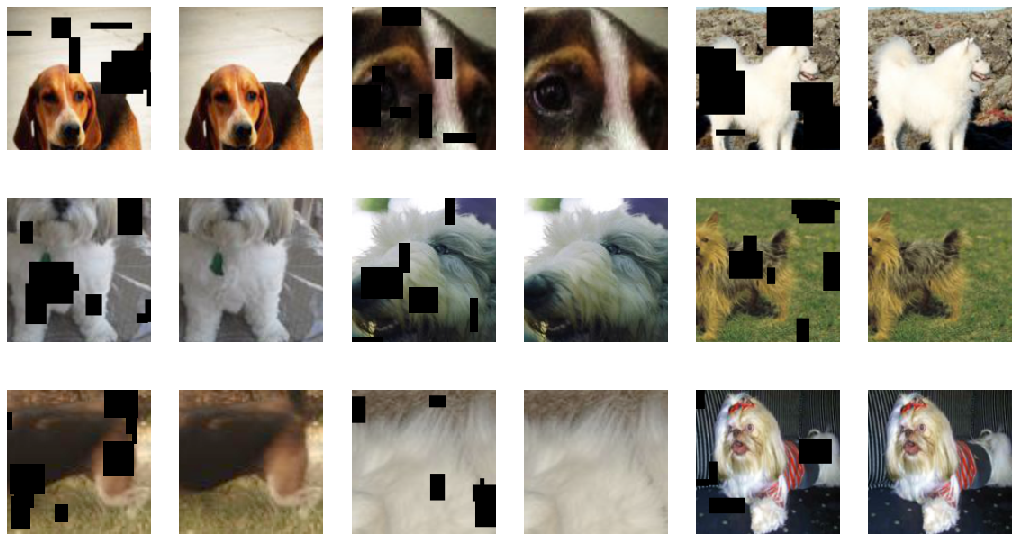

In [39]:
databunch.show_batch(max_n=9)

In [46]:
loss = MSELoss()
learn = unet_learner(databunch, resnet34, pretrained=False, config=unet_config(), loss_func=loss)

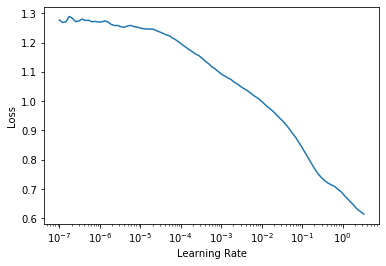

In [48]:
learn.lr_find()

This graph might be a little misleading. I suspect many of the early epochs are spent just learning to copy input pixels to output pixels.

epoch,train_loss,valid_loss,time
0,0.008041,0.011437,01:39
1,0.009670,0.012152,01:39
2,0.008992,0.009156,01:38
3,0.007287,0.006209,01:38
4,0.006772,0.004691,01:38
5,0.007105,0.004490,01:38
6,0.006299,0.004441,01:38
7,0.004935,0.003188,01:38
8,0.004702,0.002975,01:37
9,0.003917,0.002721,01:37


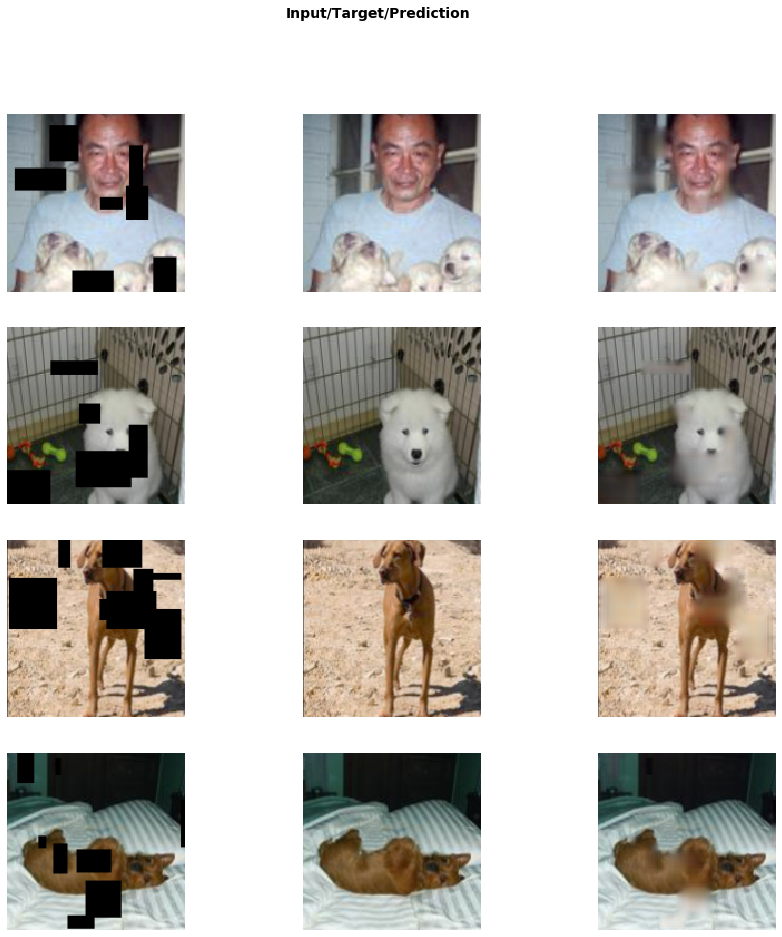

In [49]:
learn.fit_one_cycle(15, 1e-1)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))

epoch,train_loss,valid_loss,time
0,0.008415,0.012816,01:37
1,0.007028,0.004539,01:38
2,0.007462,0.005704,01:38
3,0.008845,0.010426,01:37
4,0.007417,0.005179,01:37
5,0.007690,0.007992,01:37
6,0.007049,0.005434,01:37
7,0.007198,0.005381,01:38
8,0.006215,0.003374,01:39
9,0.005903,0.004339,01:37


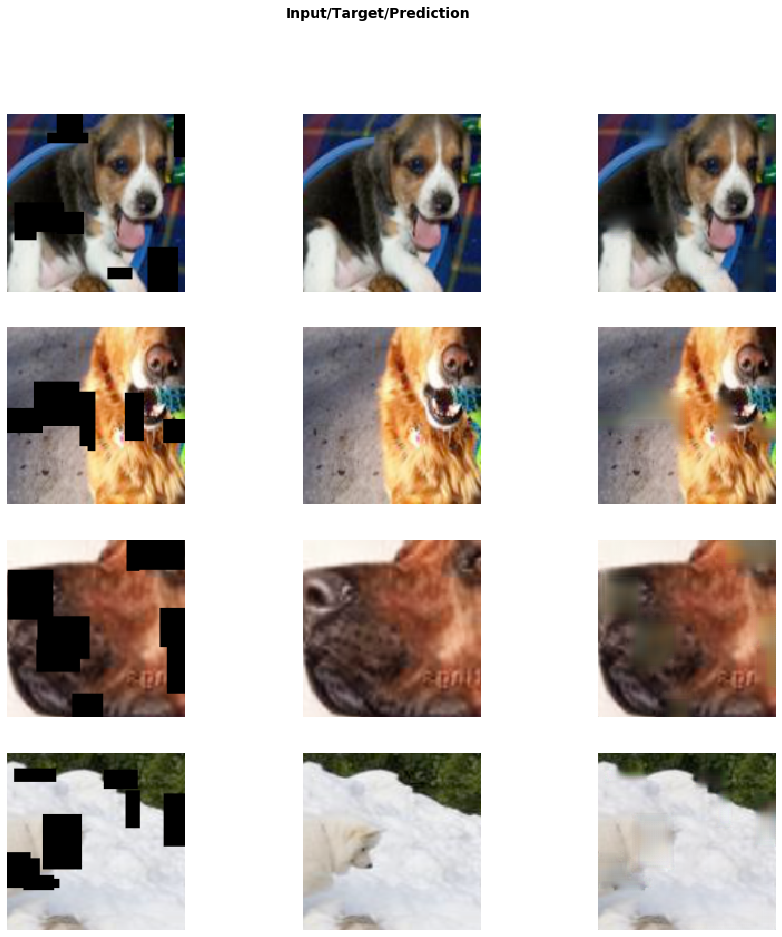

In [50]:
loss = MSELoss()
learn = unet_learner(databunch, resnet34, pretrained=False, config=unet_config(), loss_func=loss)trn_ids
learn.fit_one_cycle(15, 1e-1)
learn.predict(databunch.train_ds.items[0]);
learn.show_results(max_n=4, figsize=(15,15))